# Решающее дерево для задачи регрессии


Ваше домашнее задание состоит из 2 частей, задания 1-3 включают в себя имплементацию алгоритма Решающего дерева для задачи регрессии, в задании 4 необходимо применить метод решающего дерева к набору данных стоимости квартир.

# 1. Починить имплементацию решающего дерева

Ниже представлена наивная имплементация алгоритма Решающего дерева для задачи регрессии и пример запуска. В качестве критерия остановки выступает максимальная глубина дерева и минимальное количество наблюдений в листе.

Вам необходимо внести несколько изменений:

    1.1  Сейчас параметр `min_samples_leaf` не используется, таким образом в листах дерева может оказаться произвольное количество наблюдений, вам необходимо это починить.
    1.2 Для удобства отслеживания числа наблюдений в каждом узле добавьте поле "support" (количество наблюдейний в текущем узле) в словарь `self.tree`.

In [120]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth, min_samples_leaf):
        """
        max_depth, int - максимальная глубина дерева
        min_samples_leaf, int - минимальное количество наблюдений в листе
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _split_data(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        return X_left, y_left, X_right, y_right
    
    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)
    
    def _best_split(self, X, y):
        best_feature_index, best_threshold = None, None
        best_mse = float('inf')
        n_features = X.shape[1]
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                mse_split = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature_index = feature_index
                    best_threshold = threshold
        return best_feature_index, best_threshold
    
    def _build_tree(self, X, y, depth):
        ##new criteria for stopping
        if depth == self.max_depth or len(X) <= self.min_samples_leaf:
            return np.mean(y)
        feature_index, threshold = self._best_split(X, y)
        support = len(X)
        if feature_index is None:
            return np.mean(y)
        X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
        ##add support field
        tree = {
            'feature_index': feature_index,
            'threshold': threshold,
            'support': support
        }
        tree['left'] = self._build_tree(X_left, y_left, depth + 1)
        tree['right'] = self._build_tree(X_right, y_right, depth + 1)
        return tree
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _predict_one(self, tree, x):
        if isinstance(tree, float):
            return tree
        feature_index, threshold = tree['feature_index'], tree['threshold']
        if x[feature_index] <= threshold:
            return self._predict_one(tree['left'], x)
        else:
            return self._predict_one(tree['right'], x)
        
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self._predict_one(self.tree, x)
            predictions.append(prediction)
        return np.array(predictions)

In [121]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)

In [122]:
from sklearn.datasets import fetch_openml
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [123]:
X, y = fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
X = X.dropna(axis=1)
X = X.loc[:, X.dtypes == 'int64']
X.drop('Id', axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [124]:
X

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,...,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,...,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,...,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,...,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,460,0,40,0,0,0,0,0,8,2007
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,500,349,0,0,0,0,0,0,2,2010
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,240,366,0,112,0,0,0,0,4,2010


In [125]:
clf = dt.fit(X.values, y.values)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [126]:
dt.predict(X.values[:5])

array([194238.74476987, 124907.77836879, 194238.74476987, 194238.74476987,
       314894.55384615])

In [127]:
dt.tree

{'feature_index': 2,
 'threshold': 7,
 'support': 1460,
 'left': {'feature_index': 2,
  'threshold': 6,
  'support': 1231,
  'left': {'feature_index': 13,
   'threshold': 1376,
   'support': 912,
   'left': 124907.77836879433,
   'right': 165466.08908045976},
  'right': {'feature_index': 13,
   'threshold': 1935,
   'support': 319,
   'left': 194238.74476987447,
   'right': 247980.9875}},
 'right': {'feature_index': 2,
  'threshold': 8,
  'support': 229,
  'left': {'feature_index': 13,
   'threshold': 1970,
   'support': 168,
   'left': 249392.46601941748,
   'right': 314894.55384615384},
  'right': {'feature_index': 11,
   'threshold': 1538,
   'support': 61,
   'left': 371942.2586206897,
   'right': 708333.3333333334}}}

# 2. Воспользуйтесь `line_profiler` 

Текущая имплементация Решающего дерева работает очень медленно. Чтобы локализовать что отнимает так много времени воспользуйтесь `line_profiler`.

    2.1 Что занимает больше всего времени на этапе обучения решающего дерева?  
      
      Ответ: больше всего занимает нахождение лучшего признака и лучшего значения в нем при разбиении, что правильно, ведь приходится сравнивать MSE при разбиениям по всем уникальным значениям в каждом признаке 
    
https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [128]:
pip install line_profiler


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [129]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [130]:
%lprun -f dt._build_tree dt._build_tree(X.values[:100], y.values[:100], 7)

Timer unit: 1e-09 s

Total time: 0.559124 s
File: /var/folders/c6/67fcc9qx15q9fyw75tswhtl80000gn/T/ipykernel_24240/3764655031.py
Function: _build_tree at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
    41                                               def _build_tree(self, X, y, depth):
    42                                                   ##new criteria for stopping
    43         5      12000.0   2400.0      0.0          if depth == self.max_depth or len(X) <= self.min_samples_leaf:
    44         3      69000.0  23000.0      0.0              return np.mean(y)
    45         2  558948000.0    3e+08    100.0          feature_index, threshold = self._best_split(X, y)
    46         2       2000.0   1000.0      0.0          support = len(X)
    47         2       2000.0   1000.0      0.0          if feature_index is None:
    48                                                       return np.mean(y)
    49         2      75000.0  37500.0      0.0          X

# 3. Гистограммы

Вместо того чтобы перебирать все уникальные значения признака в методе `self._best_split` мы будем восстанавливать гистограмму распределения признака и перебирать только уникальные значения в бинах, см. пример:

In [131]:
x = np.random.normal(0, 1, 200)

In [132]:
len(np.unique(x))

200

In [133]:
bins_height, bins_edges = np.histogram(x, bins=10)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

In [134]:
len(bins_centers)

10

Т.е. вместо "200" уникальных трешхолдов мы будем использовать только "10".

In [135]:
import matplotlib.pyplot as plt

In [136]:
bins_centers

array([-2.67942761, -2.09341021, -1.50739282, -0.92137542, -0.33535803,
        0.25065937,  0.83667676,  1.42269416,  2.00871155,  2.59472895])

In [137]:
# Ширина бинов одинакова
bins_edges[:-1]-bins_edges[1:] 

array([-0.58601739, -0.58601739, -0.58601739, -0.58601739, -0.58601739,
       -0.58601739, -0.58601739, -0.58601739, -0.58601739, -0.58601739])

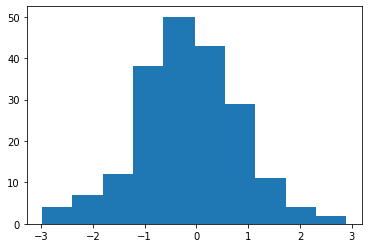

In [138]:
plt.bar(bins_centers, bins_height, width=0.6);

### Выбор числа бинов

Количество бинов гистограммы может сильно повлиять на то как вы приближаете ваше распределение

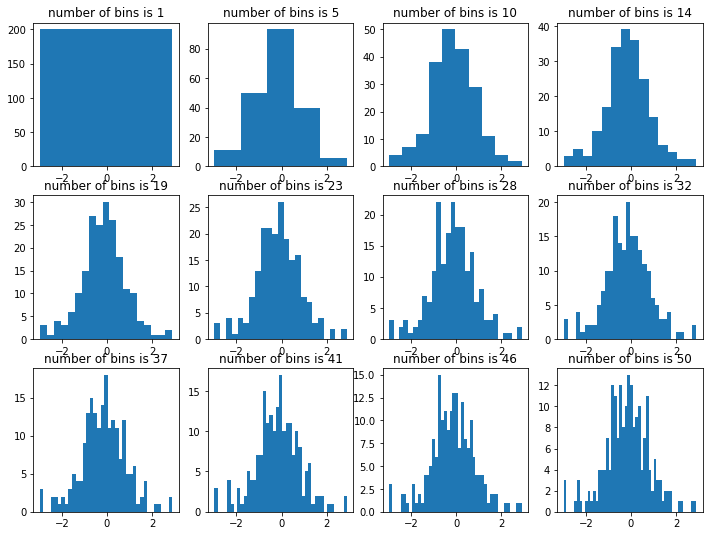

In [139]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
n_bins = np.round(np.linspace(1, 50, 12)).astype(int)

for i, ax in enumerate(axs.flatten()):
    ax.hist(x, bins=n_bins[i])
    ax.set_title(f'number of bins is {n_bins[i]}')

### Метод Freedman–Diaconis 

https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

Для выбора числа бинов в гистограмме воспользуйте правилом Freedman–Diaconis:

$$\text{Bin width} = 2 \cdot \frac{IQR(x)}{n^{1/3}}$$

Где IQR это inter quartile range, то есть расстояние между 25 и 75 перцентилем распределения.

    3.1 Метод Freedman–Diaconis дает формулу для ширины бина (одинаковая для всех бинов), а чему в таком случае равно число бинов?   
      
      Ответ:  (max(x)-min(x))/bin_width
    3.2 Имплементируйте функцию для подсчета числа бинов по формуле Freedman–Diaconis

In [141]:
# iqr
np.quantile(x, 0.75) - np.quantile(x, 0.25)

1.1531464862433398

In [142]:
def freedman_number(x):
    iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
    bin_width = 2*iqr/len(x)**(1/3)
    if bin_width > 0:
        bin_number = (max(x)-min(x))/bin_width
        return bin_number
    else: 
        return -1

In [143]:
freedman_number(x)

14.859562754100997

### В методе `self._best_split` замените перебор всех уникальных трешхолдов на перебор только по уникальным бинам

Количество бинов подбирайте методом Freedman–Diaconis

    3.3 Засеките время обучения вашего регрессора до и после имплементации гистограмм, насколько быстрее стало обучение?  
      
      Ответ: стало в 2-3 раза быстрее при выборке длиной 100  
      
    3.4 Сравните скорость работы вашей имплементации решающего дерева и имплементации sklearn.tree.DecisionTreeRegressor, с аналогичными гиперпараметрами  
      
      Ответ: имплементация sklearn на 2 порядка быстрее, что говорит о том, что в нашей имплементации еще есть что улучшать  
      
    3.5 Опишите другие способы ускорения алгоритма решающего дерева (кроме приближения распределений признаков гистограмми)  
      
      Ответ: можно предложить динамическое программирование : если отсортировать объекты по какому-то признаку, то, проходя по отсортированному массиву, можно одновременно и перебирать все значения предикатов, и поддерживать все необходимые статистики для пересчёта значений информативности за O(1) для каждого следующего варианта сплита

In [144]:
class DecisionTreeRegressorWithHist(DecisionTreeRegressor):
    def _best_split(self, X, y):
        best_feature_index, best_threshold = None, None
        best_mse = float('inf')
        n_features = X.shape[1]

        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            bins_number = freedman_number(feature_values)
            if bins_number != -1:
                bins_number = int(bins_number)
                bins_height, bins_edges = np.histogram(feature_values, bins=bins_number)
                ##make the centers of bins the thresholds
                thresholds = (bins_edges[:-1]+bins_edges[1:])/2
            else:
                ##if binwidth is 0, then make like in the 1 variant with unique values
                thresholds = np.unique (feature_values)
            
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                mse_split = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature_index = feature_index
                    best_threshold = threshold
        return best_feature_index, best_threshold

        

In [145]:
# %%timeit
dt_hist = DecisionTreeRegressorWithHist(max_depth=3, min_samples_leaf=50)
clf = dt_hist.fit(X.values, y.values)
dt_hist.predict(X.values[:5])

array([194013.62068966, 127111.77414075, 194013.62068966, 194013.62068966,
       308268.78947368])

In [146]:
%lprun -f dt_hist._build_tree dt_hist._build_tree(X.values[:100], y.values[:100], 7)

Timer unit: 1e-09 s

Total time: 0.192753 s
File: /var/folders/c6/67fcc9qx15q9fyw75tswhtl80000gn/T/ipykernel_24240/3764655031.py
Function: _build_tree at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
    41                                               def _build_tree(self, X, y, depth):
    42                                                   ##new criteria for stopping
    43         5      13000.0   2600.0      0.0          if depth == self.max_depth or len(X) <= self.min_samples_leaf:
    44         3      64000.0  21333.3      0.0              return np.mean(y)
    45         2  192594000.0    1e+08     99.9          feature_index, threshold = self._best_split(X, y)
    46         2       3000.0   1500.0      0.0          support = len(X)
    47         2       2000.0   1000.0      0.0          if feature_index is None:
    48                                                       return np.mean(y)
    49         2      66000.0  33000.0      0.0          X

In [147]:
from sklearn.tree import DecisionTreeRegressor

In [149]:
# %%timeit
regr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
regr.fit(X.values, y.values)
regr.predict(X.values[:5])

array([194238.74476987, 124907.77836879, 194238.74476987, 194238.74476987,
       314894.55384615])

# 4. House pricing

воспользуйтесь набором данных из ДЗ2. Обучите алгоритм Решающего дерева (воспользуйтесь имплементацией из sklearn), не забудьте разделить данные на тренировочную и тестовую выборки. 

    4.1. Влияет ли нормировка признаков на алгоритм Решающего дерева? Почему?  
      
      Ответ: практически никак не влияет, так как деревья не подвержены никаким монотонным преобразованиям, так как критерием является меньше или больше. Это означает, что реальной информацией из атрибутов для поиска разбиения (и всего дерева) является только порядок значений. А это значит, что если мы преобразуем атрибуты таким образом, чтобы сохранить исходный порядок, получим то же самое дерево.  
        
    4.2. Переберите различные значения гиперпараметров решающего дерева с использованием функции GridSearchCV, какое наилучшее качество в терминах mean_squared_error вам удалось получить? Насколько это лучше/хуже качества линейных моделей (на том же train-test разбиении).  
      
       Ответ: train-test разбиение 70:30   
        У решающего дерева с лучшими параметрами MSE = 4.67e+10
        У линейной регрессии было наилучшее MSE = 4.460069e+10  
      Как мы видим по порядку величины не отличаются  
        
        
    4.3. Сравните важность признаков которую предлагает встроенный метод DecisionTreeRegressor().feature_importances_ с важностью признаков полученной для линейных моделей, прокомментируйте.  
      
      Ответ: важными признаками в решающем дереве оказались sqft_living, grade, yr_built(остальные признаки и вовсе занулились, то есть по ним не происходило разбиение)  
      При использовании линейной регрессии также среди важных признаков были также sqft_living, grade, yr_built, но и еще bedrooms, waterfront и view.  
      То, что важные признаки остаются такими же, говорит нам о том, то наше дерево работает верно и правильно производит отбор разделения

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [151]:
X = pd.read_csv('kc_house_data_train.csv', index_col=0)
y = X.price
X = X.drop(["id", 'zipcode', 'lat', 'long', 'price', 'date'], axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=5)

In [152]:
tree = DecisionTreeRegressor(max_depth=13, min_samples_leaf=50)
tree.fit(X_train, y_train)
y_pred_val = tree.predict(X_val)

print("MSE val:", mse(y_val, y_pred_val))

n_scaler = MinMaxScaler()
X_train_scaled_n = n_scaler.fit_transform(X_train)
X_val_scaled_n = n_scaler.transform(X_val)

norm = tree.fit(X_train_scaled_n, y_train)
y_pred_val_n = norm.predict(X_val_scaled_n)

print("MSE val MinMaxScaler:", mse(y_val, y_pred_val_n))

z_scaler = StandardScaler()
X_train_scaled = z_scaler.fit_transform(X_train)
X_val_scaled = z_scaler.transform(X_val)

scaled = tree.fit(X_train_scaled, y_train)
y_pred_val_z = scaled.predict(X_val_scaled)

print("MSE val StandardScaler:", mse(y_val, y_pred_val_z))

MSE val: 46799461347.36352
MSE val MinMaxScaler: 46800087953.57903
MSE val StandardScaler: 46797150169.206604


In [153]:
params_grid = {
    'criterion': ['squared_error'],
    'max_depth': np.arange(3, 30),
    'min_samples_split': np.arange(10, 30, 5)
}
cv = ShuffleSplit(test_size=0.30, n_splits=1)
gs = GridSearchCV(tree, param_grid=params_grid, cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

gs.best_estimator_

Fitting 1 folds for each of 108 candidates, totalling 108 fits


DecisionTreeRegressor(max_depth=13, min_samples_leaf=50, min_samples_split=10)

In [154]:
y_pred_val = gs.predict(X_val)

print("MSE val:", mse(y_val, y_pred_val))

MSE val: 46799461347.36352


In [115]:
dict = {}
for i in range(len(X.columns)):
    dict[X.columns[i]] = tree.feature_importances_[i]
print(dict)

{'bedrooms': 0.00017188542585037334, 'bathrooms': 0.016433161970328163, 'sqft_living': 0.2965239372594896, 'sqft_lot': 0.002328761540875573, 'floors': 0.0002455687604012326, 'waterfront': 0.0, 'view': 0.004599216393615382, 'condition': 0.00030076338217624194, 'grade': 0.5339476848699479, 'sqft_above': 0.0015486663143982847, 'sqft_basement': 0.0005262892337970276, 'yr_built': 0.09216525026169864, 'yr_renovated': 0.0, 'sqft_living15': 0.04217277068514863, 'sqft_lot15': 0.009036043902272937}


jupyter notebook c вашим решением необходимо отправить на почту kurmukovai@gmail.com, с темой письма [iitp-intro-ds-2024-ha4-Surname], например [iitp-intro-ds-2024-ha4-Kurmukov] до 12:59:59 МСК 29.02.2024. Дополнительный балл за раннюю сдачу до 23:59:59 27.02.2024